In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import random
import math
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.metrics import confusion_matrix

import seaborn as sns

Initial informations

In [27]:
subject = 'c7'
# path = '/home/paolo/cvsa_ws/record/' + subject + '/dataset/psd_a_cf_00.mat'
# path = '/home/paolo/cvsa_ws/record/' + subject + '/dataset/logband_d_cf_00_band_814.mat'
# path = '/home/paolo/cvsa_ws/record/' + subject + '/dataset/logband_d_cf_00_band_814_correct.mat'
# path = '/home/paolo/cvsa_ws/record/' + subject + '/dataset/logband_e_cf_00_band_814.mat'
path = '/home/paolo/cvsa_ws/record/' + subject + '/dataset/logband_e_cf_00_band_814_correct.mat'
data = loadmat(path)

type_ = 'psd' if 'psd_' in path else 'logbandpower'

In [31]:
# usign start test variable
X = data['X']
y = data['y']
y = y.ravel()

start_test = data['info'][0][0][11][0][0]

X_train = X[:start_test,:]
y_train = y[:start_test].ravel()
X_test = X[start_test:,:]
y_test = y[start_test:].ravel()


In [29]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3057, 5), (3057,), (804, 5), (804,))

In [28]:
# usign FILES start variables
X = data['X']
y = data['y']
y = y.ravel()

# last file is the test set
start_test = data['info'][0][0][9][-2][0]
info = data['info']

X_train = X[:start_test,:]
y_train = y[:start_test].ravel()
X_test = X[start_test:,:]
y_test = y[start_test:].ravel()

In [10]:
def print_cm(cm, title, tick_labels):

    # Create a heatmap
    plt.figure(figsize=(3,2))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)
    
    # Add labels and titles
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()
    
    # print accuracy
    print('Accuracy:', np.trace(cm)/np.sum(cm))
    print('Accuracy 730:', cm[0][0]/(cm[0][0]+cm[0][1]))
    print('Accuracy 731:', cm[1][1]/(cm[1][0]+cm[1][1]))
    
    

In [11]:
def print_cm_rej(model, X, y_true, th_rej, title, ticket_label):
    cm = [[0, 0], [0, 0]]
    y_probs = model.predict_proba(X)
    
    for idx_p in range(len(y_probs)):
        if y_true[idx_p] == 730 and y_probs[idx_p,0] > th_rej:
            cm[0][0] += 1 
        elif y_true[idx_p] == 730 and y_probs[idx_p, 1] > th_rej:
            cm[0][1] += 1
        elif y_true[idx_p] == 731 and y_probs[idx_p, 1] > th_rej:
            cm[1][1] += 1
        elif y_true[idx_p] == 731 and y_probs[idx_p, 0] > th_rej:
            cm[1][0] += 1
       
    print_cm(cm, title, ticket_label)
    

In [12]:
def accuracy_online(prob, hit, miss, timeout, target, ths):
        
    i1 = np.where(prob[:,0] > ths[0])[0]
    if len(i1) == 0:
        i1 = len(prob[:,0]) + 1
    else:
        i1 = i1[0]
    i2 = np.where(prob[:,0] < ths[1])[0]
    if len(i2) == 0:
        i2 = len(prob[:,0]) + 1
    else:
        i2 = i2[0]
        
        
    
    if (target == 730 and i1 < i2) or (target == 731 and i1 > i2):
        hit += 1
    elif (target == 730 and i1 > i2) or (target == 731 and i1 < i2):
        miss += 1
    elif i1 == i2:
        timeout += 1
        
    return hit, miss, timeout
        
    

## QDA

In [30]:
param_grid = {'reg_param': [0.0, 0.1, 0.5, 1.0], 'priors': [None, [0.5, 0.5]]}

#grid_search = GridSearchCV(estimator=QuadraticDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=3).fit(X_train, y_train)
grid_search = GridSearchCV(estimator=QuadraticDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)

#print("Results: ", grid_search.cv_results_)
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'priors': [0.5, 0.5], 'reg_param': 0.1}
Best score found:  0.5940796722398726


In [31]:
model_qda = QuadraticDiscriminantAnalysis(reg_param=grid_search.best_params_['reg_param'], store_covariance=True, priors=grid_search.best_params_['priors'])
model_qda.fit(X_train, y_train)

print(f'Accuracy train: {model_qda.score(X_train, y_train)}')
print(f'Accuracy test:  {model_qda.score(X_test, y_test)}')
print(f'Accuracy all:   {model_qda.score(X, y)}')

Accuracy train: 0.6018972849198561
Accuracy test:  0.7064676616915423
Accuracy all:   0.6236726236726237


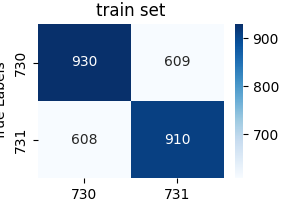

Accuracy: 0.6018972849198561
Accuracy 730: 0.6042884990253411
Accuracy 731: 0.5994729907773386


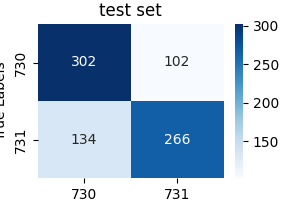

Accuracy: 0.7064676616915423
Accuracy 730: 0.7475247524752475
Accuracy 731: 0.665


In [38]:
print_cm_rej(model_qda, X_train, y_train, 0.5, 'train set',  ['730', '731'])
print_cm_rej(model_qda, X_test,  y_test,  0.5, 'test set',  ['730', '731'])

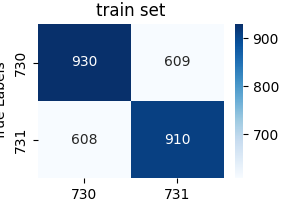

Accuracy: 0.6018972849198561
Accuracy 730: 0.6042884990253411
Accuracy 731: 0.5994729907773386


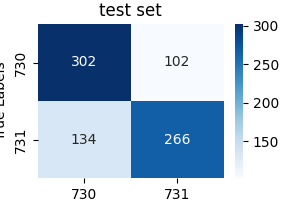

Accuracy: 0.7064676616915423
Accuracy 730: 0.7475247524752475
Accuracy 731: 0.665


In [37]:
print_cm(confusion_matrix(y_train, model_qda.predict(X_train)), 'train set', ['730', '731'])
print_cm(confusion_matrix(y_test, model_qda.predict(X_test)), 'test set', ['730', '731'])

In [20]:
# look only test data
%matplotlib widget
alpha = 0.98
y_inter = 0.5
tmp = data['info'][0][0][6].ravel()
cfStart = tmp[tmp >= start_test] - start_test # in this way the data are takn from X_test
cfDur = data['info'][0][0][7].ravel()
cfDur = cfDur[tmp >= start_test]

maxDur = np.max(cfDur)

fig, axs = plt.subplots(math.ceil(len(cfStart)/4), 4, sharex=True, sharey=True)
fig.set_size_inches(10,10)

hit, miss, timeout = 0, 0, 0
if '_d_' in path or '_e_' in path or '_f_' in path or '_g_' in path or '_h_' in path or '_i_' in path or '_j_' in path:
    ths = [0.90, 0.10]
else:
    ths = [0.55, 0.45]

for i in range(len(cfStart)):
    
    c_start = cfStart[i]
    c_end = c_start + cfDur[i]
    
    c_y = np.array([[y_inter, y_inter]])
    probs = model_qda.predict_proba(X_test[c_start:c_end,:])
    #pred = model_qda.predict(X_test[c_start:c_end,:])
    #pred[pred==731]=0
    #pred[pred==730]=1
    
    for prob in probs:
        if max(prob) > 0.5:
            c_t = alpha * c_y[-1,:] + (1 - alpha) * prob
            c_y = np.vstack([c_y, c_t])
        else:
            c_t = c_y[-1,:]
            c_y = np.vstack([c_y, c_t])
    
    [hit, miss, timeout] = accuracy_online(c_y, hit, miss, timeout, y_test[cfStart[i]], ths)
    
    axs[int(i/4), i%4].plot(c_y[:,0]) # first column is about 730 
    #axs[int(i/4), i%4].plot(pred)
    axs[int(i/4), i%4].hlines(y_inter, 0, len(c_y), colors='r')
    axs[int(i/4), i%4].set_title(f'{y_test[cfStart[i]]}')
    #axs[int(i/4), i%4].set_ylim([np.min(c_y[:,0]), np.max(c_y[:,0])])
    axs[int(i/4), i%4].set_xlim([0, maxDur])

print(f'Online accuracy: {hit/(hit+miss+timeout)}, hit: {hit}, miss: {miss}, timeout: {timeout}')

plt.tight_layout()
plt.show()


    

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 50

In [22]:
# Save the qda model for psd

#import joblib
#joblib.dump(model_qda, 'model_qda.joblib')

from ruamel.yaml import YAML
from ruamel.yaml.comments import CommentedSeq
from ruamel.yaml.scalarstring import LiteralScalarString

means = ''
for i in range(0, len(model_qda.means_[0])):
    means = means + f'{model_qda.means_[0][i]} {model_qda.means_[1][i]};\n' 
covs = ""
for i in range(0, len(model_qda.covariance_[0][0])):
    for j in range(0, len(model_qda.covariance_[0][0])):
        covs = covs + f'{model_qda.covariance_[0][i][j]} {model_qda.covariance_[1][i][j]};\n'


info = data['info']

freqs = ""
for i in range(len(info[0][0][2])):
    c_f = info[0][0][2][i][0][0].tolist()
    for j in range(len(c_f)):
        if j == 0:
            freqs = freqs + f"{c_f[j]}"
        else:
            freqs = freqs + f" {c_f[j]}"
    freqs = freqs + ";\n"
    
features_label = []
for i in range(0,len(info[0][0][3][0])):
    features_label.append(info[0][0][3][0][i].tolist())
    
    
model_params = {
    'QdaCfg': {
        'name': "qda",
        'params': {
            'subject': subject,
            'filename': path,
            'type_data': type_,
            'nclasses': int(len(model_qda.classes_)),
            'classlbs': model_qda.classes_.tolist(),
            'nfeatures': int(model_qda.n_features_in_),
            'chans': CommentedSeq(features_label),
            'idchans': info[0][0][12][0].tolist(),
            'sampleRate': int(info[0][0][1][0][0]),
            'freqs': LiteralScalarString(freqs),
            'priors': model_qda.priors_.tolist(),
            'means': LiteralScalarString(means),
            'covs': LiteralScalarString(covs)
        }
    }
}
yaml = YAML()
yaml.default_flow_style = None 

model_params['QdaCfg']['params']['chans'].fa.set_flow_style()

#path = '/home/paolo/cvsa_ws/record/' + subject + '/qdaCfg.yaml'
path = 'qdaCfg.yaml'

with open(path, 'w') as file:
    yaml.dump(model_params, file)


In [12]:
# Save the qda model for logbandpower

#import joblib
#joblib.dump(model_qda, 'model_qda.joblib')

from ruamel.yaml import YAML
from ruamel.yaml.comments import CommentedSeq
from ruamel.yaml.scalarstring import LiteralScalarString

means = ''
for i in range(0, len(model_qda.means_[0])):
    means = means + f'{model_qda.means_[0][i]} {model_qda.means_[1][i]};\n' 
covs = ""
for i in range(0, len(model_qda.covariance_[0][0])):
    for j in range(0, len(model_qda.covariance_[0][0])):
        covs = covs + f'{model_qda.covariance_[0][i][j]} {model_qda.covariance_[1][i][j]};\n'


info = data['info']
features_label = []
for i in range(0,len(info[0][0][2][0])):
    features_label.append(info[0][0][2][0][i].tolist())
    
    
model_params = {
    'QdaCfg': {
        'name': "qda",
        'params': {
            'subject': subject,
            'filename': path,
            'type_data': type_,
            'nclasses': int(len(model_qda.classes_)),
            'classlbs': model_qda.classes_.tolist(),
            'nfeatures': int(model_qda.n_features_in_),
            'chans': CommentedSeq(features_label),
            'idchans': info[0][0][12][0].tolist(),
            'sampleRate': int(info[0][0][1][0][0]),
            'band': info[0][0][5][0].tolist(),
            'filterOrder': int(info[0][0][8][0][0]),
            'priors': model_qda.priors_.tolist(),
            'means': LiteralScalarString(means),
            'covs': LiteralScalarString(covs)
        }
    }
}
yaml = YAML()
yaml.default_flow_style = None 

model_params['QdaCfg']['params']['chans'].fa.set_flow_style()

#path = '/home/paolo/cvsa_ws/record/' + subject + '/qdaCfg.yaml'
path = 'qdaCfg.yaml'

with open(path, 'w') as file:
    yaml.dump(model_params, file)


In [52]:
import pandas as pd
import csv

with open('logbandpower_features.csv', 'w') as f:
   writer = csv.writer(f)
   writer.writerows(X_test)
   
with open('logbandpower_labels.csv', 'w') as f:
   writer = csv.writer(f)
   tmp = data['y']
   a = tmp[start_test:]
   writer.writerows(a)
   
with open('logbandpower_pred.csv', 'w') as f:
   writer = csv.writer(f)
   writer.writerows(model_qda.predict_proba(X_test))

## Gaussian processing

In [33]:
param_grid = {'kernel': [1.0 * RBF(length_scale=1.0), 2.0 * RBF(length_scale=1.0), 3.0 * RBF(length_scale=1.0),
                         1.0 * Matern(length_scale=1.0, nu=1.5), 2.0 * Matern(length_scale=1.0, nu=1.5), 3.0 * Matern(length_scale=1.0, nu=1.5)]}
#grid_search = GridSearchCV(estimator=GaussianProcessClassifier(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=3).fit(X_train, y_train)
grid_search = GridSearchCV(estimator=GaussianProcessClassifier(), param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)

print("Results: ", grid_search.cv_results_)
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Results:  {'mean_fit_time': array([249.00110717, 248.26558123, 248.78337393, 228.64220834,
       220.58051281, 206.78647618]), 'std_fit_time': array([22.71214052, 27.18633552, 21.65789595, 15.43683646, 11.8308839 ,
       10.85786885]), 'mean_score_time': array([0.07397366, 0.09723301, 0.07892213, 0.0884994 , 0.06170301,
       0.04004655]), 'std_score_time': array([0.00449433, 0.0199796 , 0.01079093, 0.01650752, 0.01922951,
       0.00586902]), 'param_kernel': masked_array(data=[1**2 * RBF(length_scale=1),
                   1.41**2 * RBF(length_scale=1),
                   1.73**2 * RBF(length_scale=1),
                   1**2 * Matern(length_scale=1, nu=1.5),
                   1.41**2 * Matern(length_scale=1, nu=1.5),
                   1.73**2 * Matern(length_scale=1, nu=1.5)],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'kernel': 1**2 * RBF(length_scale=1)}, {'kernel': 1.41**2 * RBF(length_scale=1)},

In [34]:
model_gaussian = GaussianProcessClassifier(kernel=grid_search.best_params_['kernel'])
model_gaussian.fit(X_train, y_train)

print(f'Accuracy train: {model_gaussian.score(X_train, y_train)}')
print(f'Accuracy test:  {model_gaussian.score(X_test, y_test)}')
print(f'Accuracy all:   {model_gaussian.score(X, y)}')

Accuracy train: 0.8338240104677789
Accuracy test:  0.6293532338308457
Accuracy all:   0.7912457912457912


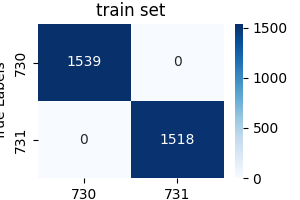

Accuracy: 1.0
Accuracy 730: 1.0
Accuracy 731: 1.0


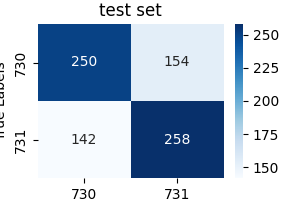

Accuracy: 0.6318407960199005
Accuracy 730: 0.6188118811881188
Accuracy 731: 0.645


In [21]:
print_cm_rej(model_gaussian, X_train, y_train, 0.5, 'train set',  ['730', '731'])
print_cm_rej(model_gaussian, X_test,  y_test,  0.5, 'test set',  ['730', '731'])

Online accuracy: 0.5, hit: 5, miss: 4, timeout: 1


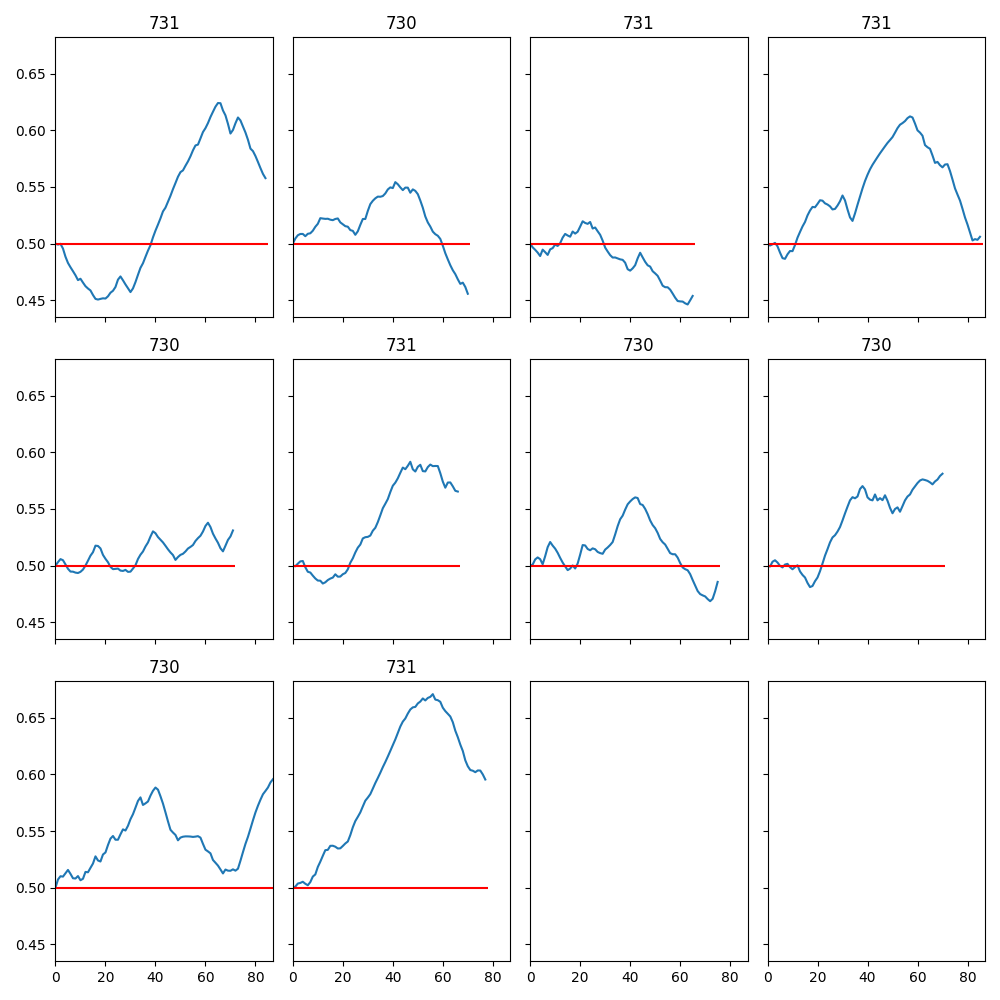

In [339]:
# look only test data
%matplotlib widget
alpha = 0.98
y_inter = 0.5
tmp = data['info'][0][0][6].ravel()
cfStart = tmp[tmp >= start_test] - start_test # in this way the data are takn from X_test
cfDur = data['info'][0][0][7].ravel()
cfDur = cfDur[tmp >= start_test]

maxDur = np.max(cfDur)

fig, axs = plt.subplots(math.ceil(len(cfStart)/4), 4, sharex=True, sharey=True)
fig.set_size_inches(10,10)

hit, miss, timeout = 0, 0, 0
if '_d_' in path or '_e_' in path or '_f_' in path or '_g_' in path or '_h_' in path or '_i_' in path or '_j_' in path:
    ths = [0.8, 0.2]
else:
    ths = [0.55, 0.45]

for i in range(len(cfStart)):
    
    c_start = cfStart[i]
    c_end = c_start + cfDur[i]
    
    c_y = np.array([[y_inter, y_inter]])
    probs = model_gaussian.predict_proba(X_test[c_start:c_end,:])
    #pred = model_gaussian.predict(X_test[c_start:c_end,:])
    #pred[pred==731]=0
    #pred[pred==730]=1
    
    for prob in probs:
        if max(prob) > 0.5:
            c_t = alpha * c_y[-1,:] + (1 - alpha) * prob
            c_y = np.vstack([c_y, c_t])
        else:
            c_t = c_y[-1,:]
            c_y = np.vstack([c_y, c_t])
    
    [hit, miss, timeout] = accuracy_online(c_y, hit, miss, timeout, y_test[cfStart[i]], ths)
    
    axs[int(i/4), i%4].plot(c_y[:,0]) # first column is about 730 
    #axs[int(i/4), i%4].plot(pred)
    axs[int(i/4), i%4].hlines(y_inter, 0, len(c_y), colors='r')
    axs[int(i/4), i%4].set_title(f'{y_test[cfStart[i]]}')
    #axs[int(i/4), i%4].set_ylim([np.min(c_y[:,0]), np.max(c_y[:,0])])
    axs[int(i/4), i%4].set_xlim([0, maxDur])

print(f'Online accuracy: {hit/(hit+miss+timeout)}, hit: {hit}, miss: {miss}, timeout: {timeout}')

plt.tight_layout()
plt.show()
    

## LDA

In [35]:
param_grid = {'solver': [ 'lsqr', 'eigen'], 'shrinkage': ['auto', None]}

#grid_search = GridSearchCV(estimator=LinearDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=3).fit(X_train, y_train)
grid_search = GridSearchCV(estimator=LinearDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)

print("Results: ", grid_search.cv_results_)
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Results:  {'mean_fit_time': array([0.00848198, 0.01289749, 0.00507097, 0.00487318]), 'std_fit_time': array([0.00089312, 0.00065934, 0.00077489, 0.00120203]), 'mean_score_time': array([0.00106597, 0.00108519, 0.00111814, 0.00092235]), 'std_score_time': array([0.00015955, 0.00015936, 0.00015933, 0.00017512]), 'param_shrinkage': masked_array(data=['auto', 'auto', None, None],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_solver': masked_array(data=['lsqr', 'eigen', 'lsqr', 'eigen'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'shrinkage': 'auto', 'solver': 'lsqr'}, {'shrinkage': 'auto', 'solver': 'eigen'}, {'shrinkage': None, 'solver': 'lsqr'}, {'shrinkage': None, 'solver': 'eigen'}], 'split0_test_score': array([0.45424837, 0.45424837, 0.4754902 , 0.4754902 ]), 'split1_test_score': array([0.65359477, 0.65359477, 0.62418301, 0.62418301]), 'split2_test_score': array([

In [36]:
model_lda = LinearDiscriminantAnalysis(solver=grid_search.best_params_['solver'], shrinkage=grid_search.best_params_['shrinkage'])
model_lda.fit(X_train, y_train)

print(f'Accuracy train: {model_lda.score(X_train, y_train)}')
print(f'Accuracy test:  {model_lda.score(X_test, y_test)}')
print(f'Accuracy all:   {model_lda.score(X, y)}')

Accuracy train: 0.6454039908406934
Accuracy test:  0.7238805970149254
Accuracy all:   0.6617456617456617


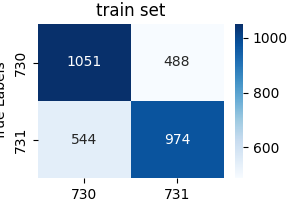

Accuracy: 0.662414131501472
Accuracy 730: 0.6829109811565952
Accuracy 731: 0.6416337285902504


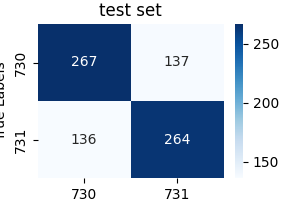

Accuracy: 0.6604477611940298
Accuracy 730: 0.6608910891089109
Accuracy 731: 0.66


In [22]:
print_cm_rej(model_lda, X_train, y_train, 0.5, 'train set',  ['730', '731'])
print_cm_rej(model_lda, X_test,  y_test,  0.5, 'test set',  ['730', '731'])

In [23]:
# look only test data
%matplotlib widget
alpha = 0.98
y_inter = 0.5
tmp = data['info'][0][0][6].ravel()
cfStart = tmp[tmp >= start_test] - start_test # in this way the data are takn from X_test
cfDur = data['info'][0][0][7].ravel()
cfDur = cfDur[tmp >= start_test]

maxDur = np.max(cfDur)

fig, axs = plt.subplots(math.ceil(len(cfStart)/4), 4, sharex=True, sharey=True)
fig.set_size_inches(10,10)

hit, miss, timeout = 0, 0, 0
if '_d_' in path or '_e_' in path or '_f_' in path or '_g_' in path or '_h_' in path or '_i_' in path or '_j_' in path:
    ths = [0.80, 0.25]
else:
    ths = [0.55, 0.45]

for i in range(len(cfStart)):
    
    c_start = cfStart[i]
    c_end = c_start + cfDur[i]
    
    c_y = np.array([[y_inter, y_inter]])
    probs = model_lda.predict_proba(X_test[c_start:c_end,:])
    #pred = model_lda.predict(X_test[c_start:c_end,:])
    #pred[pred==731]=0
    #pred[pred==730]=1
    
    for prob in probs:
        if max(prob) > 0.5:
            c_t = alpha * c_y[-1,:] + (1 - alpha) * prob
            c_y = np.vstack([c_y, c_t])
        else:
            c_t = c_y[-1,:]
            c_y = np.vstack([c_y, c_t])
    
    [hit, miss, timeout] = accuracy_online(c_y, hit, miss, timeout, y_test[cfStart[i]], ths)
    
    axs[int(i/4), i%4].plot(c_y[:,0]) # first column is about 730 
    #axs[int(i/4), i%4].plot(pred)
    axs[int(i/4), i%4].hlines(y_inter, 0, len(c_y), colors='r')
    axs[int(i/4), i%4].set_title(f'{y_test[cfStart[i]]}')
    #axs[int(i/4), i%4].set_ylim([np.min(c_y[:,0]), np.max(c_y[:,0])])
    axs[int(i/4), i%4].set_xlim([0, maxDur])

print(f'Online accuracy: {hit/(hit+miss+timeout)}, hit: {hit}, miss: {miss}, timeout: {timeout}')

plt.tight_layout()
plt.show()
    

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 50

In [85]:
x_tr = model_lda.transform(X_train)
plt.figure()
plt.scatter(x_tr[:,0], range(0, len(x_tr[:,0])), c=y_train)
plt.show()

NotImplementedError: transform not implemented for 'lsqr' solver (use 'svd' or 'eigen').

## SVM

In [24]:
from sklearn.svm import SVC

param_grid = {'kernel': [1.0 * RBF(length_scale=1.0), 2.0 * RBF(length_scale=1.0), 3.0 * RBF(length_scale=1.0), 2.0 * RBF(length_scale=2.0)],
              'C' : np.logspace(-2, 4, 3),
              'gamma' : np.logspace(-9, 3, 3)}

cv = [(np.arange(0,int(len(X_train)*0.7)), np.arange(int(len(X_train)*0.7), len(X_train)))]
grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=cv, n_jobs=-1).fit(X_train, y_train)
#grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=cv, n_jobs=-1, verbose=3).fit(X_train, y_train)

print("The best parameters are %s with a score of %0.4f" % (grid_search.best_params_, grid_search.best_score_))

The best parameters are {'C': 10.0, 'gamma': 1e-09, 'kernel': 1.41**2 * RBF(length_scale=2)} with a score of 0.6264


In [25]:
svm = SVC(kernel=grid_search.best_params_['kernel'], C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'], probability=True)
svm.fit(X_train, y_train)
print(f'Accuracy train: {svm.score(X_train, y_train)}')
print(f'Accuracy test:  {svm.score(X_test, y_test)}')
print(f'Accuracy all:   {svm.score(X, y)}')
 

Accuracy train: 0.878966306836768
Accuracy test:  0.6094527363184079
Accuracy all:   0.8228438228438228


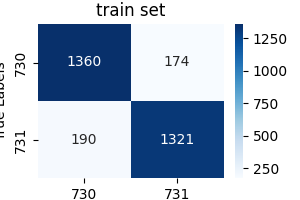

Accuracy: 0.8804597701149425
Accuracy 730: 0.8865710560625815
Accuracy 731: 0.8742554599602912


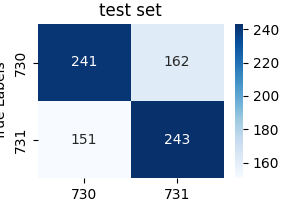

Accuracy: 0.6072772898368883
Accuracy 730: 0.598014888337469
Accuracy 731: 0.616751269035533


In [26]:
print_cm_rej(svm, X_train, y_train, 0.5, 'train set',  ['730', '731'])
print_cm_rej(svm, X_test,  y_test,  0.5, 'test set',  ['730', '731'])

Online accuracy: 0.6, hit: 6, miss: 3, timeout: 1


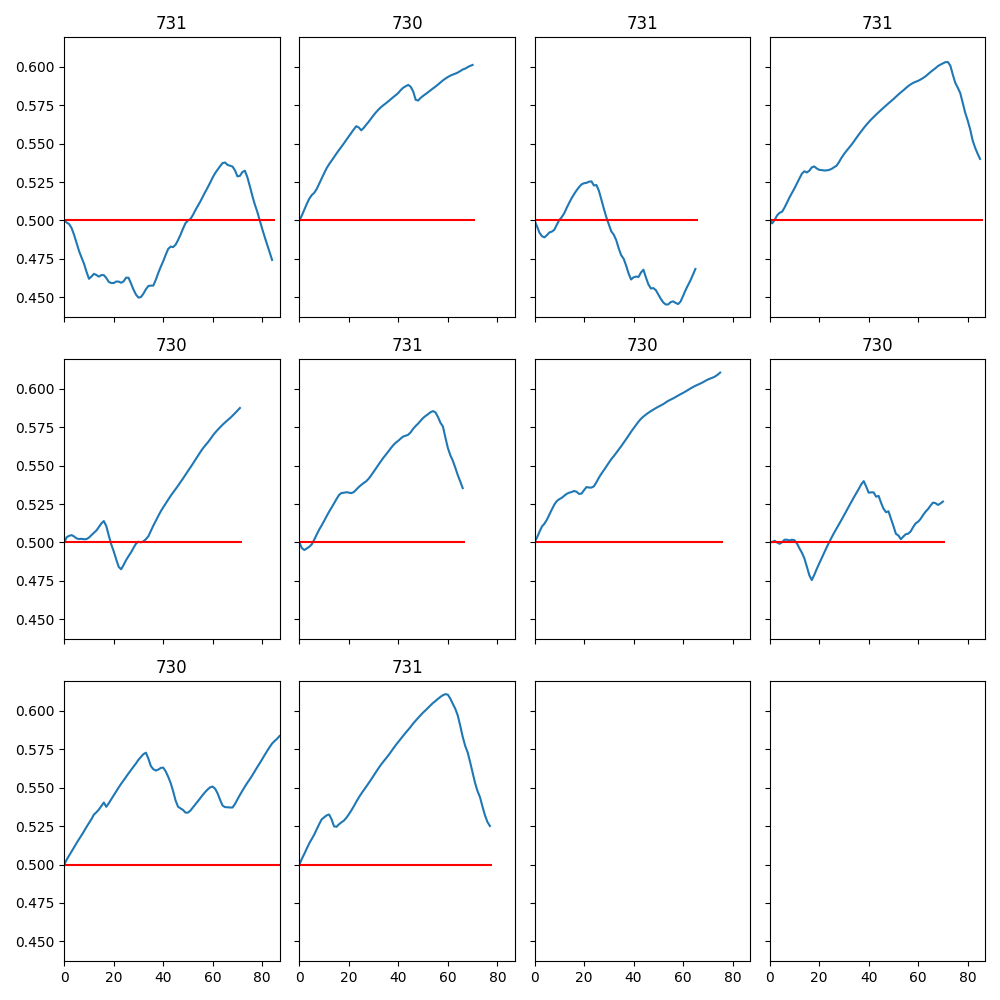

In [345]:
# look only test data
%matplotlib widget
alpha = 0.98
y_inter = 0.5
tmp = data['info'][0][0][6].ravel()
cfStart = tmp[tmp >= start_test] - start_test # in this way the data are takn from X_test
cfDur = data['info'][0][0][7].ravel()
cfDur = cfDur[tmp >= start_test]

maxDur = np.max(cfDur)

fig, axs = plt.subplots(math.ceil(len(cfStart)/4), 4, sharex=True, sharey=True)
fig.set_size_inches(10,10)

hit, miss, timeout = 0, 0, 0
if '_d_' in path or '_e_' in path or '_f_' in path or '_g_' in path or '_h_' in path or '_i_' in path or '_j_' in path:
    ths = [0.8, 0.2]
else:
    ths = [0.55, 0.45]

for i in range(len(cfStart)):
    
    c_start = cfStart[i]
    c_end = c_start + cfDur[i]
    
    c_y = np.array([[y_inter, y_inter]])
    probs = svm.predict_proba(X_test[c_start:c_end,:])
    #pred = svm.predict(X_test[c_start:c_end,:])
    #pred[pred==731]=0
    #pred[pred==730]=1
    
    for prob in probs:
        if max(prob) > 0.5:
            c_t = alpha * c_y[-1,:] + (1 - alpha) * prob
            c_y = np.vstack([c_y, c_t])
        else:
            c_t = c_y[-1,:]
            c_y = np.vstack([c_y, c_t])
    
    [hit, miss, timeout] = accuracy_online(c_y, hit, miss, timeout, y_test[cfStart[i]], ths)
    
    axs[int(i/4), i%4].plot(c_y[:,0]) # first column is about 730 
    #axs[int(i/4), i%4].plot(pred)
    axs[int(i/4), i%4].hlines(y_inter, 0, len(c_y), colors='r')
    axs[int(i/4), i%4].set_title(f'{y_test[cfStart[i]]}')
    #axs[int(i/4), i%4].set_ylim([np.min(c_y[:,0]), np.max(c_y[:,0])])
    axs[int(i/4), i%4].set_xlim([0, maxDur])

print(f'Online accuracy: {hit/(hit+miss+timeout)}, hit: {hit}, miss: {miss}, timeout: {timeout}')

plt.tight_layout()
plt.show()
    

## Random Forest

In [61]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

model_rF = RandomForestClassifier()

param_dist = {'n_estimators': randint(0, 500), 'max_depth': randint(1, X.shape[1])}
#rand_search = RandomizedSearchCV(model_rF, param_distributions= param_dist, n_iter=15, cv=5, verbose=3).fit(X_train, y_train)
rand_search = RandomizedSearchCV(model_rF, param_distributions= param_dist, n_iter=15, cv=5).fit(X_train, y_train)

#print(rand_search.cv_results_)
#print('Best hyperparameters:', rand_search.best_params_)
print('Best score:', rand_search.best_score_)

Best score: 0.5374118514134484


In [62]:
model_rF = rand_search.best_estimator_
model_rF.fit(X_train, y_train)  

print(f'Accuracy train: {model_rF.score(X_train, y_train)}')
print(f'Accuracy test:  {model_rF.score(X_test, y_test)}')
print(f'Accuracy all:   {model_rF.score(X, y)}')

Accuracy train: 0.5511022044088176
Accuracy test:  0.549492385786802
Accuracy all:   0.5507667900581703


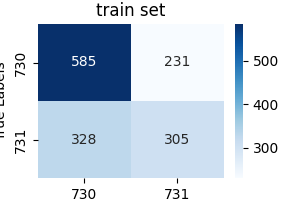

Accuracy: 0.6142167011732229
Accuracy 730: 0.7169117647058824
Accuracy 731: 0.48183254344391785


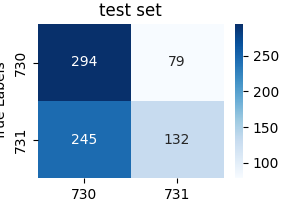

Accuracy: 0.568
Accuracy 730: 0.7882037533512064
Accuracy 731: 0.35013262599469497


In [26]:
print_cm_rej(model_rF, X_train, y_train, 0.5, 'train set',  ['730', '731'])
print_cm_rej(model_rF, X_test,  y_test,  0.5, 'test set',  ['730', '731'])

Online accuracy: 0.5, hit: 5, miss: 3, timeout: 2


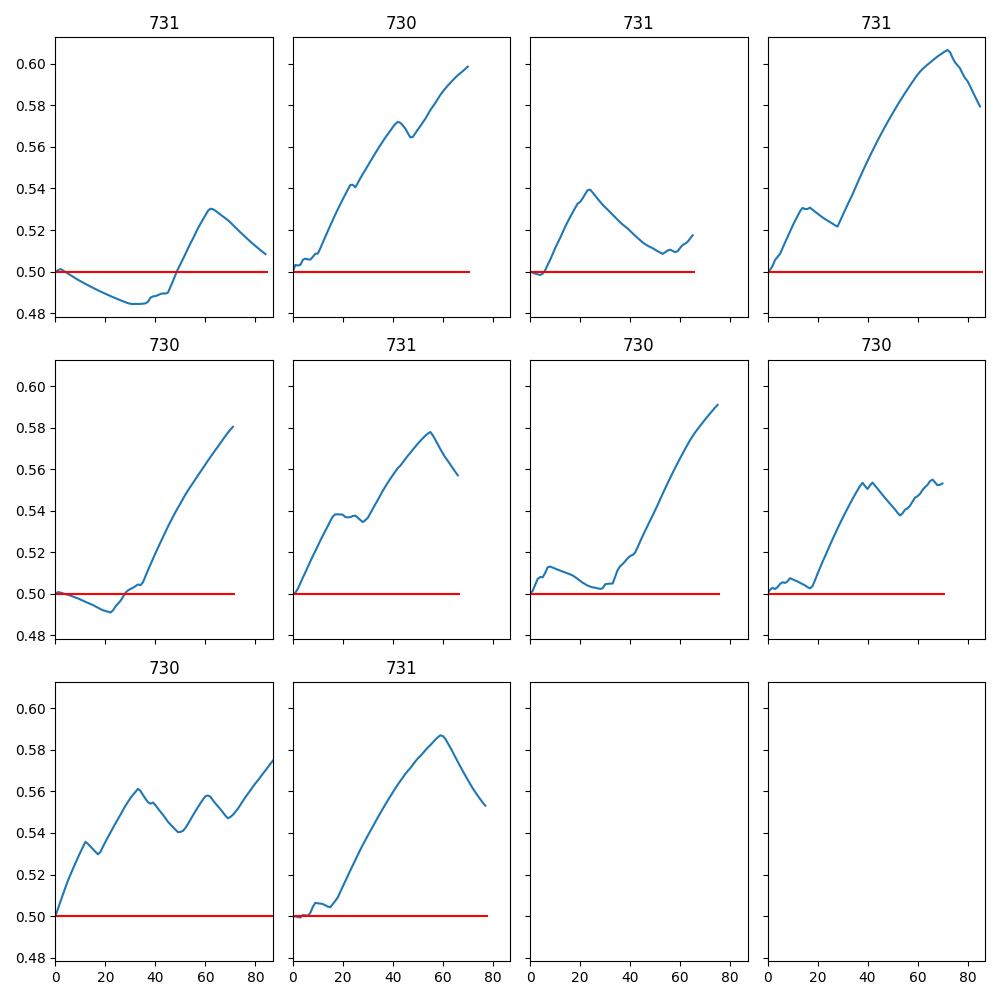

In [349]:
# look only test data
%matplotlib widget
alpha = 0.98
y_inter = 0.5
tmp = data['info'][0][0][6].ravel()
cfStart = tmp[tmp >= start_test] - start_test # in this way the data are takn from X_test
cfDur = data['info'][0][0][7].ravel()
cfDur = cfDur[tmp >= start_test]

maxDur = np.max(cfDur)

fig, axs = plt.subplots(math.ceil(len(cfStart)/4), 4, sharex=True, sharey=True)
fig.set_size_inches(10,10)

hit, miss, timeout = 0, 0, 0
if '_d_' in path or '_e_' in path or '_f_' in path or '_g_' in path or '_h_' in path or '_i_' in path or '_j_' in path:
    ths = [0.8, 0.2]
else:
    ths = [0.55, 0.45]

for i in range(len(cfStart)):
    
    c_start = cfStart[i]
    c_end = c_start + cfDur[i]
    
    c_y = np.array([[y_inter, y_inter]])
    probs = model_rF.predict_proba(X_test[c_start:c_end,:])
    #pred = model_rF.predict(X_test[c_start:c_end,:])
    #pred[pred==731]=0
    #pred[pred==730]=1
    
    for prob in probs:
        if max(prob) > 0.5:
            c_t = alpha * c_y[-1,:] + (1 - alpha) * prob
            c_y = np.vstack([c_y, c_t])
        else:
            c_t = c_y[-1,:]
            c_y = np.vstack([c_y, c_t])
    
    [hit, miss, timeout] = accuracy_online(c_y, hit, miss, timeout, y_test[cfStart[i]], ths)
    
    axs[int(i/4), i%4].plot(c_y[:,0]) # first column is about 730 
    #axs[int(i/4), i%4].plot(pred)
    axs[int(i/4), i%4].hlines(y_inter, 0, len(c_y), colors='r')
    axs[int(i/4), i%4].set_title(f'{y_test[cfStart[i]]}')
    #axs[int(i/4), i%4].set_ylim([np.min(c_y[:,0]), np.max(c_y[:,0])])
    axs[int(i/4), i%4].set_xlim([0, maxDur])

print(f'Online accuracy: {hit/(hit+miss+timeout)}, hit: {hit}, miss: {miss}, timeout: {timeout}')

plt.tight_layout()
plt.show()
    

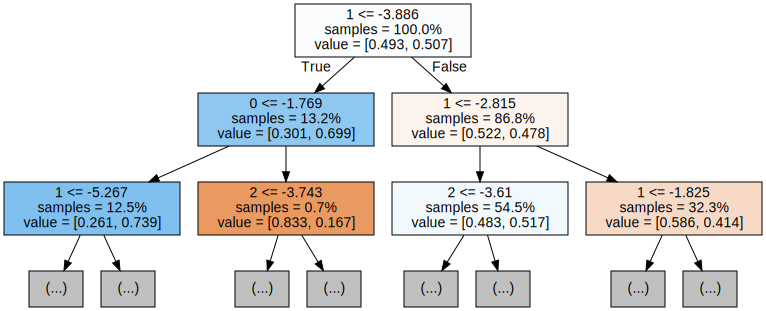

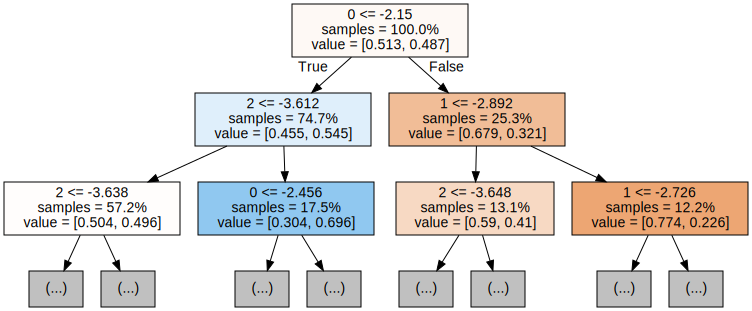

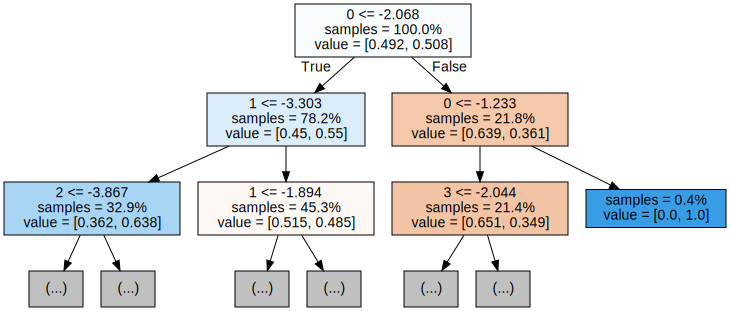

In [31]:
from sklearn.tree import export_graphviz
import graphviz
%matplotlib widget
# Visualize the first three estimators
for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
    feature_names=range(0, X.shape[1]),
    filled = True,
    max_depth = 2,
    impurity = False,
    proportion = True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Decision Tree

In [31]:
model_dT = DecisionTreeClassifier()
model_dT.fit(X_train, y_train)
print(model_dT.score(X_test, y_test))

0.5565217391304348


In [32]:
print(model_dT.score(X_train, y_train))
print(model_dT.score(X_test, y_test))
print(model_dT.score(X, y))

1.0
0.5565217391304348
0.9075847786694279


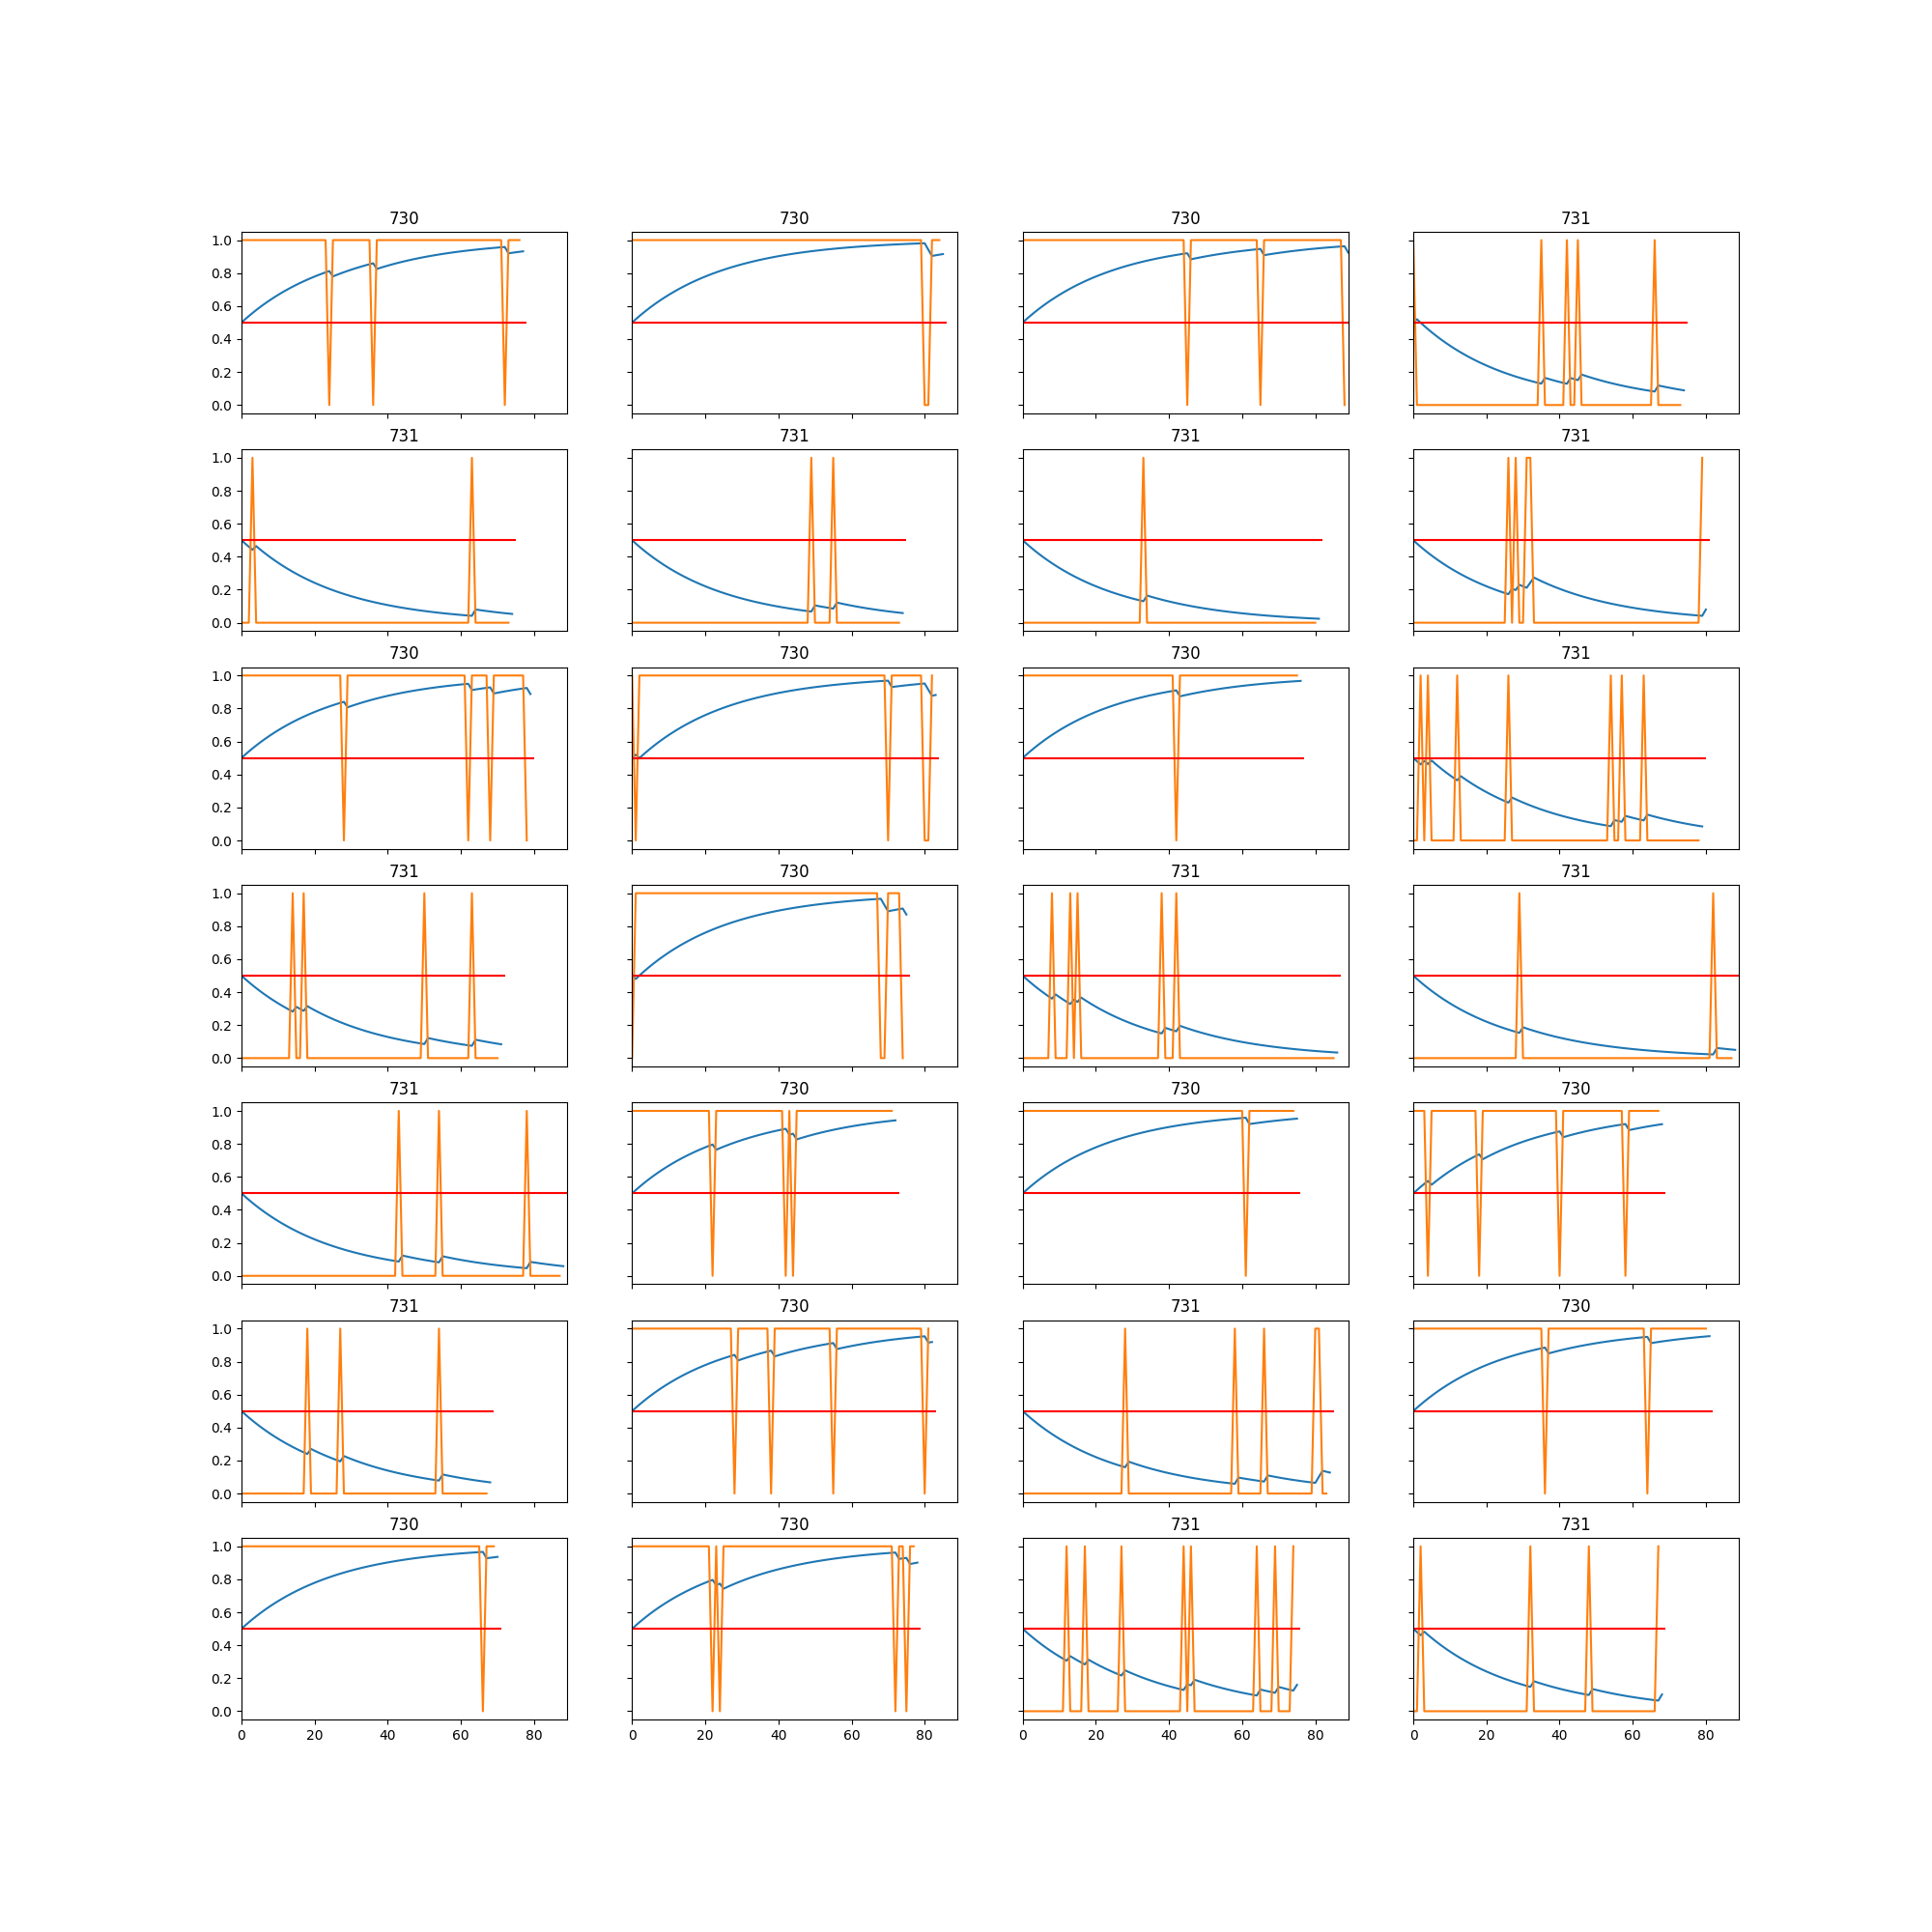

In [33]:
alpha = 0.96
y_inter = 0.5
cfStart = data['info'][0][0][6]
cfDur = data['info'][0][0][7]

maxDur = np.max(cfDur)

fig, axs = plt.subplots(int(len(cfStart)/4), 4, sharex=True, sharey=True)
fig.set_size_inches(20,20)

for i in range(len(cfStart)):
    
    c_start = cfStart[i][0]
    c_end = c_start + cfDur[i][0]
    
    c_y = np.array([y_inter, y_inter])
    probs = model_dT.predict_proba(X[c_start:c_end,:])
    pred = model_dT.predict(X[c_start:c_end,:])
    pred[pred==731]=0
    pred[pred==730]=1
    
    for prob in probs:
        c_t = alpha * c_y[-1] + (1 - alpha) * prob
        c_y = np.vstack([c_y, c_t])
    
    axs[int(i/4), i%4].plot(c_y[:,0])
    axs[int(i/4), i%4].plot(pred)
    axs[int(i/4), i%4].hlines(y_inter, 0, len(c_y), colors='r')
    axs[int(i/4), i%4].set_title(f'{y[cfStart[i][0]]}')
    #axs[int(i/4), i%4].set_ylim([np.min(c_y[:,0]), np.max(c_y[:,0])])
    axs[int(i/4), i%4].set_xlim([0, maxDur])

#plt.tight_layout()
plt.show()

## Riemman

In [1]:
import joblib
import utils

pathData = '/home/paolo/cvsa_ws/record/c7/mat_selectedTrials'
filename = '/home/paolo/cvsa_ws/record/c7_lbrb_20240509'
model_dict = joblib.load(filename)

[original_train, train_events, _, _] = utils.get_files(pathData)
train = utils.apply_laplacian(original_train)


train = utils.select_channels(train, model_dict['wantedChannels'])

filt = utils.get_bandranges(train, model_dict['bandranges'], model_dict['fs'], model_dict['filter_order'])

[covs,cov_events] = utils.get_trNorm_covariance_matrix(filt, train_events, model_dict['windowsLength'], model_dict['windowsShift'], model_dict['fs'])

n_samples = covs.shape[1]
labelVector = utils.get_CueVector_onFeedback(cov_events, n_samples)
[idx_train, idx_val] = utils.get_indices_train_validation(cov_events, [730, 731], percVal = 0.001)

covs_centered = utils.center_covariances(covs, model_dict['mean_cov'], model_dict['inv_sqrt_mean_cov'])

model = model_dict['fgmdm']

print('Predicting')
prob = model.predict_probabilities_mergeClassifier(covs_centered)

 - Computing covariance matrices on the band ranges


100%|████████████████████████████████████████| 6593/6593 [00:00<00:00, 10664.70it/s]


Predicting


In [3]:
model_dict['fgmdm'].val_accuracies
#model_dict['fgmdm'].train_accuracies
#model_dict['fgmdm'].val_confMatrix

array([[0.54636591, 0.35770235]])

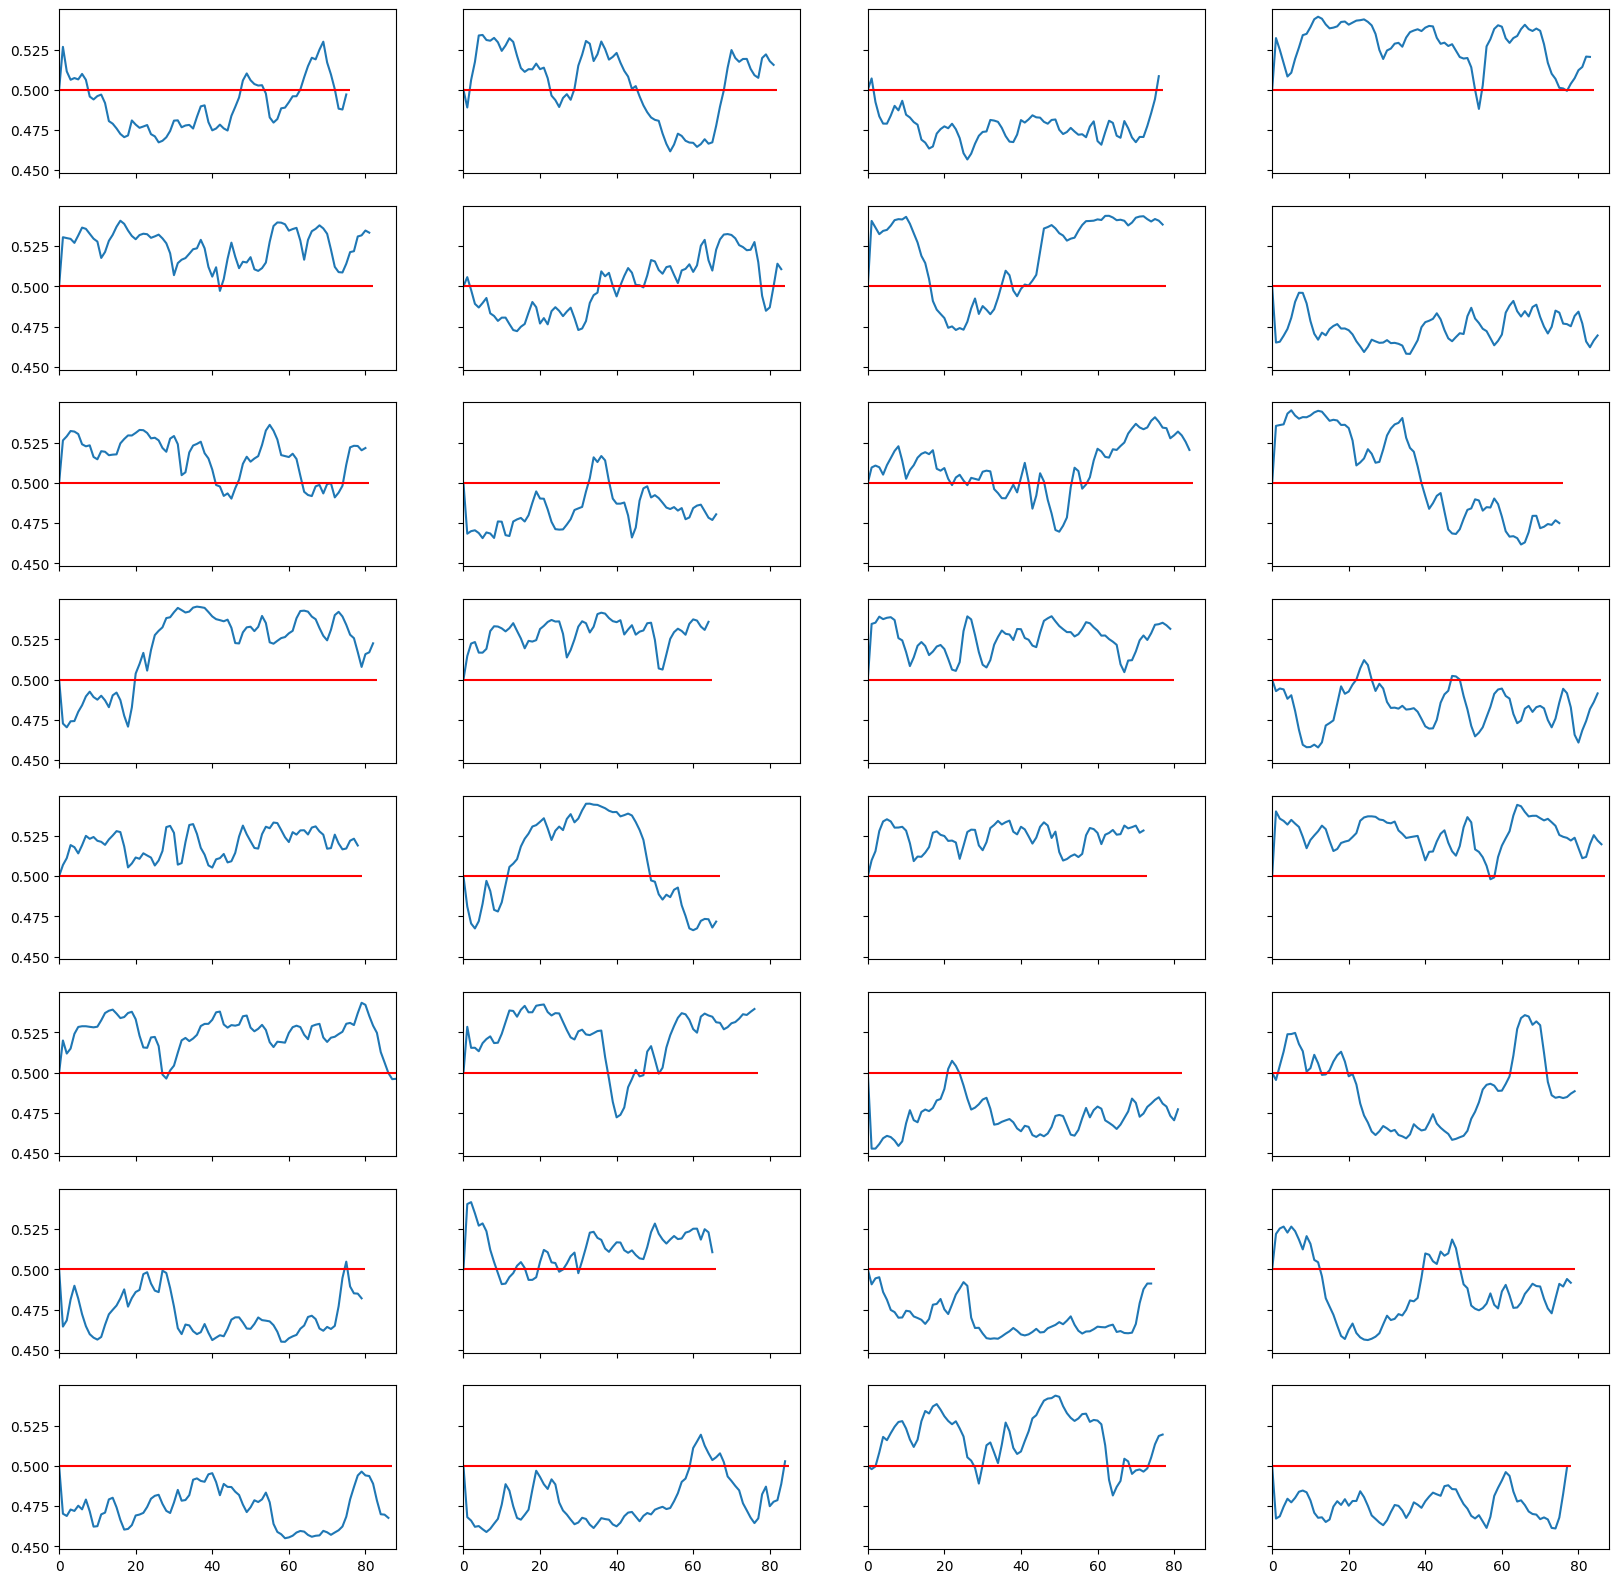

In [5]:
import matplotlib.pyplot as plt
import numpy as np

alpha = 0.9
y_inter = 0.5
cfStart = cov_events['pos'][cov_events['typ'] == 781].values
cfDur = cov_events['dur'][cov_events['typ'] == 781].values

maxDur = np.max(cfDur)

fig, axs = plt.subplots(int(len(cfStart)/4), 4, sharex=True, sharey=True)
fig.set_size_inches(20,20)

for i in range(len(cfStart)):
    
    c_start = cfStart[i]
    c_end = c_start + cfDur[i]
    
    c_y = np.array([y_inter, y_inter])
    
    probs = prob[:,c_start:c_end,:]
    
    for p in probs:
        c_t = alpha * c_y[-1] + (1 - alpha) * p
        c_y = np.vstack([c_y, c_t])
    
    #print(c_y)
    axs[int(i/4), i%4].plot(c_y[:,0])
    axs[int(i/4), i%4].hlines(y_inter, 0, len(c_y), colors='r')
    #axs[int(i/4), i%4].set_title(f'{y[cfStart[i]]}')
    axs[int(i/4), i%4].set_xlim([0, maxDur])

#plt.tight_layout()
plt.show()

## Test

In [194]:
path2 = '/home/paolo/cvsa_ws/record/dataset/20240326.mat'
data = loadmat(path2)
X_test = data['X']
y_test = data['y']
y_test = y_test.ravel()
print(model_qda.score(X_test, y_test))
print(model_lda.score(X_test, y_test))
print(model_rF.score(X_test, y_test))
print(model_dT.score(X_test, y_test))

0.4991875203119922
0.5037374065648359
0.49658758531036723
0.4926876828079298


## PCA

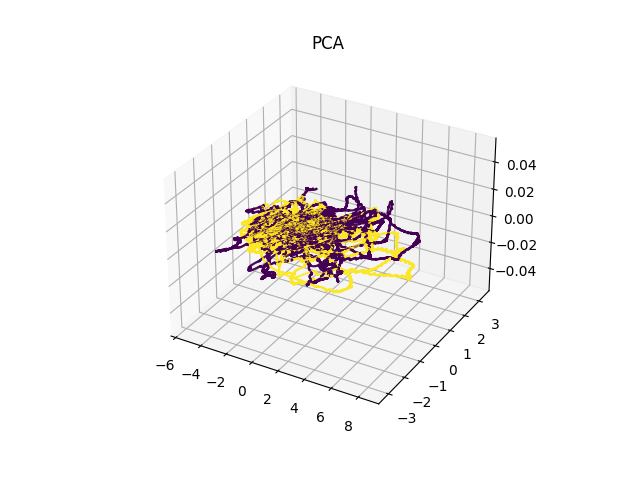

array([7.09120004e-01, 1.10604136e-01, 5.61556774e-02, 3.93730284e-02,
       1.60144553e-02, 1.31645642e-02, 1.10522583e-02, 9.29954105e-03,
       8.03200309e-03, 7.34973960e-03, 5.53535379e-03, 4.34849952e-03,
       4.06753664e-03, 3.51482212e-03, 1.30059468e-03, 6.97483806e-04,
       3.70302073e-04])

In [449]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib widget
pca = PCA()
x_pca = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('PCA')
ax.scatter(x_pca[:, 0], x_pca[:, 1], s=0.5,c=y, cmap='viridis')
plt.show()

pca.explained_variance_ratio_


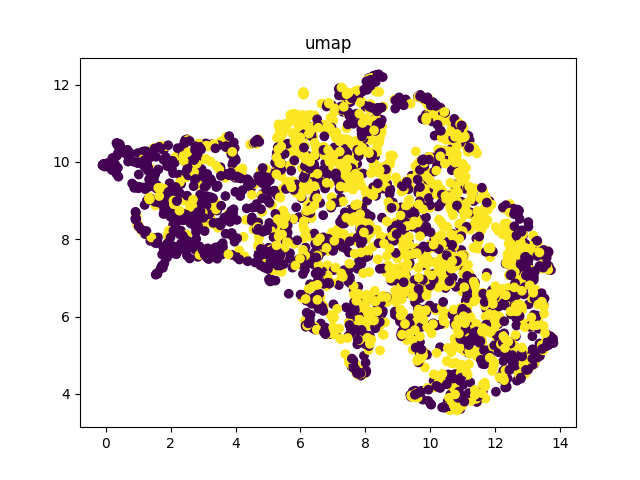

In [64]:
from umap import UMAP
umap = UMAP(n_components=2)
x_pca = umap.fit_transform(X)
plt.figure()
plt.title('umap')
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap='viridis')
plt.show()